In [15]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import DataLoader
from multiprocess import Pool
import torch
from os.path import join
from transformers import XLMRobertaTokenizerFast
from transformers import XLMRobertaForSequenceClassification
import matplotlib.pyplot as plt
import transformers
import os
import sys
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "true"

See
* https://towardsdatascience.com/transformers-can-you-rate-the-complexity-of-reading-passages-17c76da3403
* https://towardsdatascience.com/advanced-techniques-for-fine-tuning-transformers-82e4e61e16e
* https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

In [2]:
testing = False
try:
    arg = sys.argv[1]
    if arg == "test":
        testing = True
    else:
        print("couldn't recognize argument {}".format(arg))
except IndexError:
    print('running in normal mode')

couldn't recognize argument -f


In [3]:
class RIDataset(torch.utils.data.Dataset):
   
    # only 6.8% of texts (Tweets) have more than 60 non-pad tokens
    def __init__(self, texts, labels, tokenizer, seq_len=90):        
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def __len__(self):
        """Returns the length of dataset."""
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])         
        tokenized = self.tokenizer(
            text,            
            max_length = self.seq_len,                                
            padding = "max_length",     # Pad to the specified max_length. 
            truncation = True,          # Truncate to the specified max_length. 
            add_special_tokens = True,  # Whether to insert [CLS], [SEP], <s>, etc.   
            return_attention_mask = True            
        )         
        return {"ids": torch.tensor(tokenized["input_ids"], dtype=torch.long),
                "masks": torch.tensor(tokenized["attention_mask"], dtype=torch.long),
                "label": torch.tensor(self.labels[idx], dtype=torch.long)
               }

In [20]:
def loss_fn(predictions, labels):
    return torch.nn.CrossEntropyLoss()(predictions, labels)


def train_fn(data_loader, model, optimizer, device, scheduler):    
    
    model.train()                                # Put the model in training mode.              
    
    lr_list = []
    train_losses = []         
    
    for batch in tqdm(data_loader, total=len(data_loader)):                    # Loop over all batches.
        
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        labels = batch["label"].to(device, dtype=torch.long) 
        
        optimizer.zero_grad()                    # To zero out the gradients.

        outputs = model(ids, masks).logits       # Predictions from 1 batch of data.
        
        loss = loss_fn(outputs, labels)         # Get the training loss.
        train_losses.append(loss.item())

        loss.backward()                          # To backpropagate the error (gradients are computed).
        optimizer.step()                         # To update parameters based on current gradients.
        lr_list.append(optimizer.param_groups[0]["lr"])
        scheduler.step()                         # To update learning rate.
        
    return train_losses, lr_list


def validate_fn(data_loader, model, device):
        
    model.eval()                                    # Put model in evaluation mode.
    
    val_losses = []
        
    with torch.no_grad():                           # Disable gradient calculation.
        
        for batch in tqdm(data_loader, total=len(data_loader)):                   # Loop over all batches.
            
            ids = batch["ids"].to(device, dtype=torch.long)
            masks = batch["masks"].to(device, dtype=torch.long)
            labels = batch["label"].to(device, dtype=torch.long)

            outputs = model(ids, masks).logits      # Predictions from 1 batch of data.
            
            loss = loss_fn(outputs, labels)        # Get the validation loss.
            val_losses.append(loss.item())
            
    return val_losses 


def plot_train_val_losses(all_train_losses, all_val_losses, fold):
    epochs = range(1, len(all_train_losses) + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs, all_train_losses, label='training loss')
    ax.plot(epochs, all_val_losses, label='validation loss')
    ax.set_title('Fold: {}, {}'.format(fold, model_name))
    plt.savefig('losses_fold_{}.pdf'.format(fold))

In [21]:
def run_training(df, model_name):
    
    cv = []

    for fold in FOLDS:

        tokenizer =  XLMRobertaTokenizerFast.from_pretrained(model_name)
        
        # Fetch training data
        df_train = df[df["fold"] != fold].reset_index(drop=True)

        # Fetch validation data
        df_val = df[df["fold"] == fold].reset_index(drop=True)

        # Initialize training dataset
        train_dataset = RIDataset(texts = df_train["text"].values,
                                  labels = df_train["label"].values,
                                  tokenizer = tokenizer)

        # Initialize validation dataset
        val_dataset = RIDataset(texts = df_val["text"].values,
                                labels = df_val["label"].values,
                                tokenizer = tokenizer)

        # Create training dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = 2)

        # Create validation dataloader
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = 2)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = XLMRobertaForSequenceClassification\
                .from_pretrained(model_name, num_labels=2)
        model.to(device)

        optimizer = transformers.AdamW(model.parameters(), lr=1e-6)

        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS) 

        scheduler = transformers.get_scheduler(
            "linear",    # Create a schedule with a learning rate that decreases linearly 
                         # from the initial learning rate set in the optimizer to 0.
            optimizer = optimizer,
            num_warmup_steps = 0,
            num_training_steps = train_steps)


        print(f"===== FOLD: {fold} =====")    
        #best_rmse = 999
        #early_stopping_counter = 0       
        all_train_losses = []
        all_val_losses = []
        all_lr = []

        for epoch in range(EPOCHS):

            # Call the train function and get the training loss
            train_losses, lr_list = train_fn(train_data_loader, model, optimizer, device, scheduler)
            train_loss = np.mean(train_losses)   
            all_train_losses.append(train_loss)
            all_lr.extend(lr_list)

            # Perform validation and get the validation loss
            val_losses = validate_fn(val_data_loader, model, device)
            val_loss = np.mean(val_losses)
            all_val_losses.append(val_loss) 


        # Plot the losses and learning rate schedule.
        plot_train_val_losses(all_train_losses, all_val_losses, fold)

                
    # Print the cross validation scores and their average.
    cv_rounded = [ round(elem, 4) for elem in cv ] 
    print(f"CV: {cv_rounded}") 
    print(f"Average CV: {round(np.mean(cv), 4)}\n") 

N rows: 100


Some weights of the model checkpoint at models/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at models/twitter-xlm-roberta-base and are newly initialized: ['classifier.out_proj.we

===== FOLD: 0 =====


100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


CV: []
Average CV: nan



/home/jana/anaconda3/envs/ri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jana/anaconda3/envs/ri/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


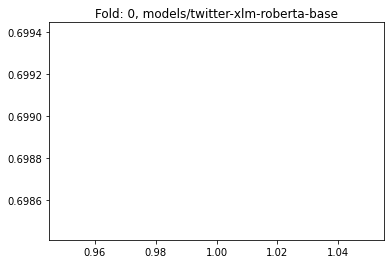

In [22]:
FOLDS = [0, 1, 2, 3, 4]
TRAIN_BS = 10
VAL_BS = 10
EPOCHS = 5
data_frac = 1
model_name = "models/twitter-xlm-roberta-base"

testing=True
if testing:
    FOLDS = FOLDS[0:1]
    EPOCHS = 1
    data_frac = 0.0001
    
src = '../../data/traindata'
df = pd.read_csv(join(src, 'dataset_DE_train.csv'))
df['label'] = df['label'].replace({'hate':1, 'counter':0})
df = df.drop(columns=['id'])
df = df.sample(frac=data_frac, random_state=42).reset_index(drop=True)
k = 5
N = len(df)
fold_size = int(N / k)
for fold in range(k):
    df.loc[fold_size * fold:fold_size * (fold + 1), "fold"] = fold
df["fold"] = df["fold"].astype(int)
print('N rows: {}'.format(len(df)))

run_training(df, model_name)